<a href="https://colab.research.google.com/github/Raashidh-Rizvi/Brain-Tumor-Detection/blob/main/model/notebook/CNN_IT24103178.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install scikeras

In [ ]:
# Step 1: Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
import tensorflow as tf

In [ ]:
!git clone https://github.com/Raashidh-Rizvi/Brain-Tumor-Detection.git


print("✅ TensorFlow version:", tf.__version__)

# Step 2: Define Dataset Paths
train_dir = "/content/Brain-Tumor-Detection/data/Training"
test_dir = "/content/Brain-Tumor-Detection/data/Testing"


# Verify dataset existence
if not os.path.exists(train_dir):
    raise ValueError(f"Training directory not found: {train_dir}")
if not os.path.exists(test_dir):
    raise ValueError(f"Testing directory not found: {test_dir}")

Cloning into 'Brain-Tumor-Detection'...
remote: Enumerating objects: 6932, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 6932 (delta 60), reused 16 (delta 2), pack-reused 6760 (from 3)
Receiving objects: 100% (6932/6932), 152.08 MiB | 23.50 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Updating files: 100% (7042/7042), done.
✅ TensorFlow version: 2.19.0


In [ ]:
# Step 3: Data Preparation and Augmentation
# ImageDataGenerator for training with augmentation and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test generator (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # For consistent evaluation
)

# Get class labels
class_labels = list(train_generator.class_indices.keys())
print(f"Class labels: {class_labels}")

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# Step 4: Define function to create CNN model (for GridSearch and varieties)
def create_cnn_model(filters1=32, filters2=64, kernel_size=(3,3), dropout=0.5, optimizer='adam', learning_rate=0.001):
    model = Sequential([
        Conv2D(filters1, kernel_size, activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(filters2, kernel_size, activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout),
        Dense(4, activation='softmax')  # 4 classes
    ])

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Step 5: Parameter Tuning with GridSearchCV
# Wrap the model for scikit-learn compatibility
model_wrapper = KerasClassifier(model=create_cnn_model, epochs=20, batch_size=32, verbose=1)

# Define parameter grid for tuning
param_grid = {
    'model__filters1': [32, 64],
    'model__filters2': [64, 128],
    'model__kernel_size': [(3,3), (5,5)],
    'model__dropout': [0.3, 0.5],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__learning_rate': [0.001, 0.0001]
}

# Grid search with 3-fold CV (on training data)
grid = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, cv=3, n_jobs=-1)
# Note: To run grid search, we need to prepare X_train, y_train as arrays (not generators)
# For simplicity, load a subset or run on full if resources allow. Here, assuming we fit on generators (but GridSearch needs arrays)

# Alternative: Manual tuning loop for varieties (since GridSearch with generators is tricky)
# We'll train 4 varieties manually

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Training Variety 1: Base


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.3924 - loss: 1.4024 - val_accuracy: 0.6275 - val_loss: 1.1236
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.6182 - loss: 0.8574 - val_accuracy: 0.6722 - val_loss: 0.9475
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.6430 - loss: 0.8447 - val_accuracy: 0.6591 - val_loss: 0.9500
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.6936 - loss: 0.7504 - val_accuracy: 0.7204 - val_loss: 0.8743
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.6792 - loss: 0.7370 - val_accuracy: 0.7038 - val_loss: 0.8585
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.7120 - loss: 0.7229 - val_accuracy: 0.6626 - val_loss: 0.9179
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.7179 - loss: 0.6992 - val_accuracy: 0.7134 - val_loss: 0.7884
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.7313 - loss: 0.6550 - val_accu

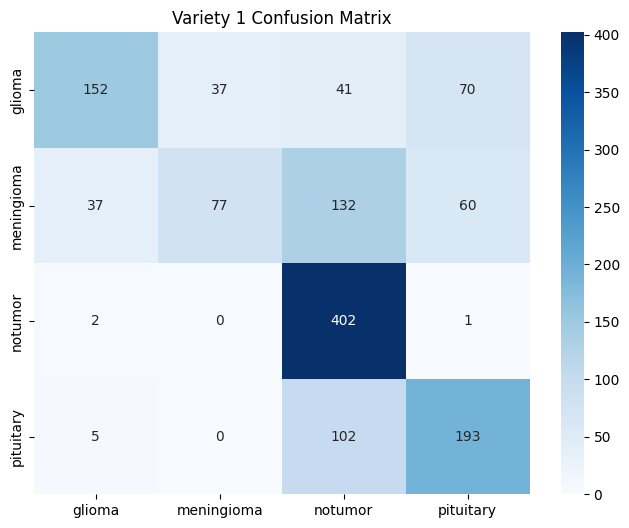

In [ ]:
# Variety 1: Base (32/64 filters, 3x3 kernel, dropout=0.5, adam, lr=0.001)
print("Training Variety 1: Base")
model_v1 = create_cnn_model(filters1=32, filters2=64, kernel_size=(3,3), dropout=0.5, optimizer='adam', learning_rate=0.001)
history_v1 = model_v1.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate on test
y_pred_v1 = model_v1.predict(test_generator)
y_pred_classes_v1 = np.argmax(y_pred_v1, axis=1)
y_true = test_generator.classes
print("Variety 1 Classification Report:\n", classification_report(y_true, y_pred_classes_v1, target_names=class_labels))
conf_matrix_v1 = confusion_matrix(y_true, y_pred_classes_v1)
auc_v1 = roc_auc_score(to_categorical(y_true), y_pred_v1, multi_class='ovr')
print(f"Variety 1 AUC: {auc_v1}")

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_v1, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Variety 1 Confusion Matrix')
plt.show()

Training Variety 2: Increased Filters


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 526s 4s/step - accuracy: 0.4249 - loss: 1.3948 - val_accuracy: 0.5486 - val_loss: 1.1624
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 519s 4s/step - accuracy: 0.6431 - loss: 0.8703 - val_accuracy: 0.6582 - val_loss: 0.9748
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 520s 4s/step - accuracy: 0.6760 - loss: 0.7981 - val_accuracy: 0.7195 - val_loss: 0.8539
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 522s 4s/step - accuracy: 0.6985 - loss: 0.7368 - val_accuracy: 0.6442 - val_loss: 0.8994
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 519s 4s/step - accuracy: 0.7185 - loss: 0.6805 - val_accuracy: 0.7108 - val_loss: 0.7913
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 519s 4s/step - accuracy: 0.7368 - loss: 0.6677 - val_accuracy: 0.7336 - val_loss: 0.7814
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 519s 4s/step - accuracy: 0.7436 - loss: 0.6452 - val_accuracy: 0.7082 - val_loss: 0.8371
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 521s 4s/step - accuracy: 0.7726 - loss: 0.5873 - val_accu

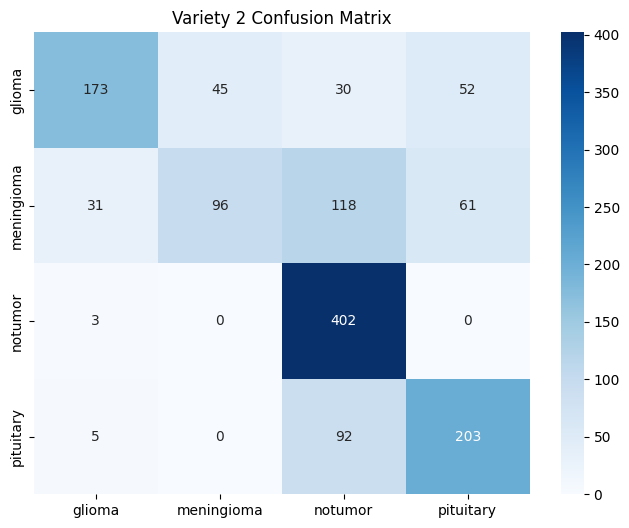

In [ ]:
# Variety 2: Increased filters (64/128, 3x3, dropout=0.3, adam, lr=0.001)
print("Training Variety 2: Increased Filters")
model_v2 = create_cnn_model(filters1=64, filters2=128, kernel_size=(3,3), dropout=0.3, optimizer='adam', learning_rate=0.001)
history_v2 = model_v2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate
y_pred_v2 = model_v2.predict(test_generator)
y_pred_classes_v2 = np.argmax(y_pred_v2, axis=1)
print("Variety 2 Classification Report:\n", classification_report(y_true, y_pred_classes_v2, target_names=class_labels))
conf_matrix_v2 = confusion_matrix(y_true, y_pred_classes_v2)
auc_v2 = roc_auc_score(to_categorical(y_true), y_pred_v2, multi_class='ovr')
print(f"Variety 2 AUC: {auc_v2}")

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_v2, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Variety 2 Confusion Matrix')
plt.show()

Training Variety 3: Larger Kernel


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.3567 - loss: 2.1948 - val_accuracy: 0.5723 - val_loss: 1.0825
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.5522 - loss: 1.0217 - val_accuracy: 0.6030 - val_loss: 0.9847
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - accuracy: 0.6404 - loss: 0.8583 - val_accuracy: 0.6345 - val_loss: 0.9524
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - accuracy: 0.6887 - loss: 0.7837 - val_accuracy: 0.6617 - val_loss: 0.9230
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.7223 - loss: 0.7233 - val_accuracy: 0.6784 - val_loss: 0.8407
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 366s 3s/step - accuracy: 0.7298 - loss: 0.6821 - val_accuracy: 0.6836 - val_loss: 0.9458
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.7394 - loss: 0.6740 - val_accuracy: 0.6915 - val_loss: 0.8211
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 368s 3s/step - accuracy: 0.7400 - loss: 0.6695 - val_accu

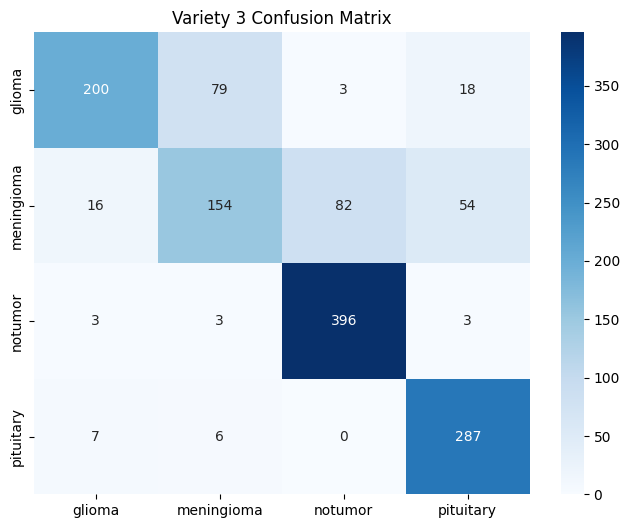

In [ ]:
# Variety 3: Larger kernel (32/64, 5x5, dropout=0.5, rmsprop, lr=0.001)
print("Training Variety 3: Larger Kernel")
model_v3 = create_cnn_model(filters1=32, filters2=64, kernel_size=(5,5), dropout=0.5, optimizer='rmsprop', learning_rate=0.001)
history_v3 = model_v3.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate
y_pred_v3 = model_v3.predict(test_generator)
y_pred_classes_v3 = np.argmax(y_pred_v3, axis=1)
print("Variety 3 Classification Report:\n", classification_report(y_true, y_pred_classes_v3, target_names=class_labels))
conf_matrix_v3 = confusion_matrix(y_true, y_pred_classes_v3)
auc_v3 = roc_auc_score(to_categorical(y_true), y_pred_v3, multi_class='ovr')
print(f"Variety 3 AUC: {auc_v3}")

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_v3, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Variety 3 Confusion Matrix')
plt.show()

Training Variety 4: Reduced Learning Rate


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.3334 - loss: 1.2949 - val_accuracy: 0.5898 - val_loss: 1.0976
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.5890 - loss: 0.9642 - val_accuracy: 0.6345 - val_loss: 0.9858
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.6311 - loss: 0.8828 - val_accuracy: 0.6670 - val_loss: 0.9725
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.6622 - loss: 0.8142 - val_accuracy: 0.6845 - val_loss: 0.9375
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.6765 - loss: 0.7755 - val_accuracy: 0.7046 - val_loss: 0.9154
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.7037 - loss: 0.7622 - val_accuracy: 0.7029 - val_loss: 0.8445
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.6974 - loss: 0.7596 - val_accuracy: 0.6819 - val_loss: 0.8606
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.7174 - loss: 0.7140 - val_accu

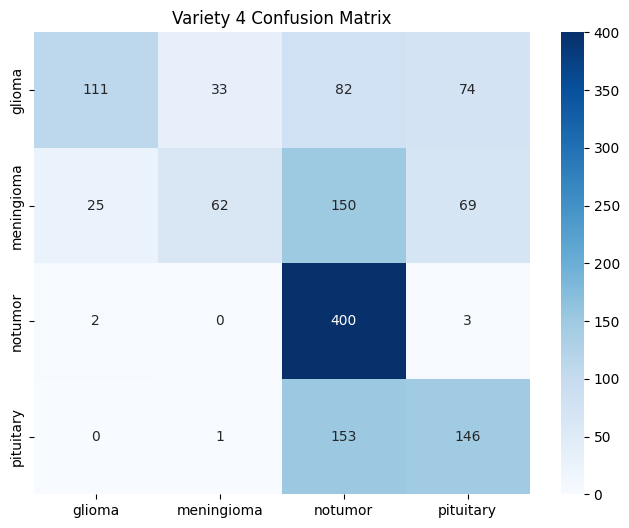

In [ ]:
# Variety 4: Reduced LR (base arch, adam, lr=0.0001, epochs=30)
print("Training Variety 4: Reduced Learning Rate")
model_v4 = create_cnn_model(filters1=32, filters2=64, kernel_size=(3,3), dropout=0.5, optimizer='adam', learning_rate=0.0001)
history_v4 = model_v4.fit(
    train_generator,
    epochs=30,  # More epochs for slower learning
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate
y_pred_v4 = model_v4.predict(test_generator)
y_pred_classes_v4 = np.argmax(y_pred_v4, axis=1)
print("Variety 4 Classification Report:\n", classification_report(y_true, y_pred_classes_v4, target_names=class_labels))
conf_matrix_v4 = confusion_matrix(y_true, y_pred_classes_v4)
auc_v4 = roc_auc_score(to_categorical(y_true), y_pred_v4, multi_class='ovr')
print(f"Variety 4 AUC: {auc_v4}")

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_v4, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Variety 4 Confusion Matrix')
plt.show()

In [ ]:
# Step 6: Comparison of Varieties
# Assuming we collect accuracies from histories or test evals
test_acc_v1 = model_v1.evaluate(test_generator)[1]
test_acc_v2 = model_v2.evaluate(test_generator)[1]
test_acc_v3 = model_v3.evaluate(test_generator)[1]
test_acc_v4 = model_v4.evaluate(test_generator)[1]

print("\nComparison:")
print(f"Variety 1 Accuracy: {test_acc_v1:.4f}, F1: {classification_report(y_true, y_pred_classes_v1, output_dict=True)['macro avg']['f1-score']:.4f}, AUC: {auc_v1:.4f}")
print(f"Variety 2 Accuracy: {test_acc_v2:.4f}, F1: {classification_report(y_true, y_pred_classes_v2, output_dict=True)['macro avg']['f1-score']:.4f}, AUC: {auc_v2:.4f}")
print(f"Variety 3 Accuracy: {test_acc_v3:.4f}, F1: {classification_report(y_true, y_pred_classes_v3, output_dict=True)['macro avg']['f1-score']:.4f}, AUC: {auc_v3:.4f}")
print(f"Variety 4 Accuracy: {test_acc_v4:.4f}, F1: {classification_report(y_true, y_pred_classes_v4, output_dict=True)['macro avg']['f1-score']:.4f}, AUC: {auc_v4:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 397ms/step - accuracy: 0.5223 - loss: 1.4403
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 872ms/step - accuracy: 0.5786 - loss: 1.3214
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 638ms/step - accuracy: 0.6894 - loss: 0.8787
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 419ms/step - accuracy: 0.4324 - loss: 2.0960

Comparison:
Variety 1 Accuracy: 0.6285, F1: 0.5853, AUC: 0.8903
Variety 2 Accuracy: 0.6667, F1: 0.6331, AUC: 0.8970
Variety 3 Accuracy: 0.7910, F1: 0.7709, AUC: 0.9351
Variety 4 Accuracy: 0.5484, F1: 0.4952, AUC: 0.8555
